In [ ]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
from starter import *
import networkx.algorithms.community as nx_comm
from collections import defaultdict
import random

In [168]:
#Find groups where each node in the group has no edges to other nodes in the group
def find_groups(G):
    coloring = nx.greedy_color(G)
    group_nos = set()
    for val in coloring.values():
        if val in group_nos:
            continue
        else:
            group_nos.add(val)
    group_dict = defaultdict(list)
    for no in coloring:
        if not(coloring[no] in group_dict):
            group_dict[coloring[no]] = [no]
        else:
            group_dict[coloring[no]].append(no)
    sets = [set(arr) for arr in group_dict.values()]
    return sets

#Confirming if find groups is correct
def check_find_groups(G, sets):
    for group in sets:
        for node in group:
            for neighbor in G.neighbors(node):
                if neighbor in group:
                    return False
    return True


#Applies the sets to graph on G copy and returns it
def return_sets_to_graph(G, sets):
    G2 = G.copy()
    for i in range(G2.number_of_nodes()):
        for group in sets:
            if i in group:
                G2.nodes[i]['team'] = sets.index(group)
    return G2

#Create a graph copy with the same input but inverse all the edge weights
def return_inverse_graph(G):
    G2 = G.copy()
    for edge in G2.edges:
        G2.edges[edge]['weight'] = 1/G2.edges[edge]['weight']
    return G2

#Create a graph copy with the same input but negate all the edge weights
def return_negate_graph(G):
    G2 = G.copy()
    for u, v, w in G2.edges.data('weight'):
        G2[u][v]['weight'] = -w
    return G2
    

In [169]:
#Solve using Asynchronous LPA Communities
def label_comm_solve(G):
    G_inv = return_inverse_graph(G)
    sets = list(nx_comm.asyn_lpa_communities(G_inv, weight='weight'))
    G = return_sets_to_graph(G, sets)

In [170]:
def max_cut_solve(G):
    #call one exchange from nx graph
    groups = nx.algorithms.approximation.maxcut.one_exchange(G, weight='weight')
    #print(groups)
    G = return_sets_to_graph(G, groups[1])

def max_cut_into_num_teams(G, num_teams):
    #keep doing one exchange until len groups[1] == num_teams
    groups = nx.algorithms.approximation.maxcut.one_exchange(G, weight='weight')
    print("Groups before while loop: ", groups)
    while len(groups[1]) != num_teams:
        #Find the best sub_graph to max cut on
        sub_graphs = [(G.subgraph(group), group) for group in groups[1]]
        best_max_cut = [0, {}]
        best_sub_graph_tuple = None
        for sub_graph_tuple in sub_graphs:
            sub_graph = sub_graph_tuple[0]
            sub_graph_max_cut = nx.algorithms.approximation.maxcut.one_exchange(sub_graph, weight='weight')
            if sub_graph_max_cut[0] > best_max_cut[0]:
                best_max_cut = sub_graph_max_cut
                best_sub_graph_tuple = sub_graph_tuple
        #remove the original subgroup from groups[1] and add the new subgroups
        print("Listed: ", list(groups[1]))
        print("Best subgraph tuple: ", best_sub_graph_tuple[1])
        list(groups[1]).remove(best_sub_graph_tuple[1])
        list(groups[1]).extend(best_max_cut[1])
    G = return_sets_to_graph(G, groups[1])



In [ ]:
G = read_input('inputs/small96.in')
max_cut_into_num_teams(G,3)
visualize(G)
score(G)

In [ ]:
tar('outputs', overwrite=True)

In [ ]:
###############################
# RANDOM PARTITIONING AND KLB #
###############################

In [187]:
#def klb as kernighan lin bisection
klb = nx.algorithms.community.kernighan_lin_bisection

#randomly divide the graph into n parts
def random_partitioning(G, n):
    part = [set() for i in range(n)]
    for i, node in enumerate(G.nodes):
        part[i % n].add(node)
    return part


#def random partitioning
def random_partitioning_2(G, num_teams):
    #get number of nodes
    num_nodes = G.number_of_nodes()
    #create a list of nodes
    nodes = list(G.nodes)
    #shuffle the list
    random.shuffle(nodes)
    #create a list of lists of nodes
    node_lists = [set() for i in range(num_teams)]
    #for each node, add it to a random list
    for i in range(num_nodes):
        node_lists[i % num_teams].add(nodes[i])
    #return the list of lists
    return node_lists

def random_partitioning_3(G, num_teams):
    num_nodes = len(G.nodes)
    #Create an array of size num_nodes and fill it with random numbers from 0 to 9
    output_arr = np.random.randint(0, num_teams, num_nodes)
    return output_arr

def local_search_random_solve(G, num_teams, max_iter):
    #NOTE: Can choose a random paritioning method here
    partition = random_partitioning(G, num_teams)
    G = return_sets_to_graph(G, partition)
    #negate the graph
    G_neg = return_negate_graph(G)
    
    for i in range(max_iter):
        for j in range(len(partition)):
            for k in range(j+1, len(partition)):
                #combine partition j and k
                tupled = (partition[j], partition[k])
                combined = partition[j].union(partition[k])
                #get subgraph of combined
                subgraph = G_neg.subgraph(combined)
                #get the best partition
                best_partition = klb(subgraph, tupled)
                #update the partition
                partition[j] = best_partition[0]
                partition[k] = best_partition[1]

                G = return_sets_to_graph(G, partition)
    
    #apply the partition to the graph
    G = return_sets_to_graph(G, partition)
    return G

# def best_lsr_solve(G, num_teams, max_iter):
#     best_score = float('inf')
#     best_partition = None
#     for i in range(1, num_teams):
#         local_search_random_solve(G, i, max_iter)
#         if score(G) < best_score:
#             #print old and new score
#             print("Old score: ", best_score, "New score: ", score(G))
#             best_score = score(G)
#             best_partition = G.copy()
#     for node in 

def big_solver(alg, num_teams, max_iter):
    def solve(G):
        m = 10**100
        g = None
        for i in range(2, num_teams+1):
            x = alg(G, i, max_iter)
            if score(x) < m:
                m = score(x)
                g = x.copy()
        return g
    return solve


In [188]:
#Genetic Algo on KLB & Random Partitioning
def ga_klb_solve(G: nx.Graph):
    #Set number of starter solutions
    n = 700
    #Generate n random nx.Graph solutions with teams set
    solutions = [random_solution(G) for i in range(n)]
    #Set number of generations
    generations = 20
    #Set number of solutions to keep
    keep = 50
    #Set number of solutions to mutate
    mutate = 20
    #Set number of solutions to crossover
    crossover = 5
    #Set number of solutions to generate
    generate = 100
    while generations > 0:
        #print(generations)
        #Evaluate fitness of solutions
        fitness = [fitness_function(solution) for solution in solutions]
        #Sort solutions by fitness
        solutions = [x for _,x in sorted(zip(fitness, solutions), key = lambda x: x[0])]
        #Keep best solutions
        solutions = solutions[:keep]
        #Mutate random solutions
        to_mutate = random.sample(range(keep), mutate)
        for i in to_mutate: #TODO: Change to random i selection
            solutions.append(mutate_solution(solutions[i]))
        #Crossover solutions
        #for i in range(crossover): #TODO: Change to random i selection
        #    solutions.append(crossover_solution(solutions[i], solutions[i+1]))
        #Generate new solutions
        for i in range(generate):
            solutions.append(random_solution(G))
        #Decrement generations
        generations -= 1
    solutions.sort(key=fitness_function)
    print(score(solutions[0]))
    best = solutions[0]
    for v in range(len(G.nodes)):
        G.nodes[v]['team'] = int(best.nodes[v]['team']) + 1
    return G
    
def fitness_function(G):
    return score(G)

def mutate_solution(G):
    G_copy = G.copy()
    #Set number of nodes to mutate
    n = len(G_copy.nodes) // 2
    #Get list of nodes
    nodes = list(G_copy.nodes)
    #Randomly select n nodes
    nodes = random.sample(nodes, n)
    #Get list of teams
    teams = list(set([G_copy.nodes[node]['team'] for node in nodes]))
    #Change team of n random nodes in G_copy to a random team
    sampled = random.sample(range(len(G_copy.nodes)), n)
    for node in sampled:
        G_copy.nodes[node]['team'] = random.choice(teams)
    return G_copy

def random_solution(G):
    #Create a copy of the graph
    G_copy = G.copy()
    #Get the number of nodes in the graph
    num_nodes = len(G.nodes)
    #num teams
    num_teams = np.random.randint(1, 20)
    #Create an array of size num_nodes and fill it with random numbers from 0 to 9
    output_arr = np.random.randint(0, num_teams, num_nodes)
    #Assign each node in the graph a team from the array
    for v in range(len(output_arr)):
        G_copy.nodes[v]['team'] = output_arr[v]
    # print("rand")
    return G_copy

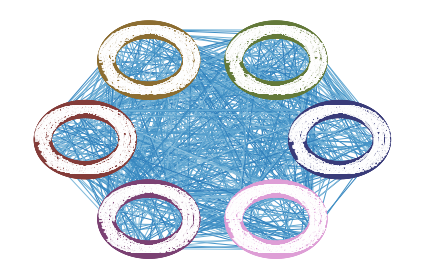

1521.951586810456

In [191]:
G = read_input('inputs/large225.in')
G = big_solver(local_search_random_solve, num_teams=10, max_iter=10)(G)
visualize(G)
score(G)